In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import madrigalWeb.madrigalWeb
import re
import h5py
import numpy as np

In [2]:
#CHANGE ME
user_fullname = "Student Example"
user_email = "isr.summer.school@gmail.com"
user_affiliation = "ISR Summer School 2020"

maddat = madrigalWeb.madrigalWeb.MadrigalData('http://cedar.openmadrigal.org/')

In [3]:
#instrument codes for AMISR
instcodes={'PFISR':61,
          'RISR-N':91,
          'RISR-C':92}

In [4]:
#start time
st=datetime.datetime(2019,1,1,0,0,0)
et=datetime.datetime(2019,1,2,0,0,0)
expList = maddat.getExperiments(instcodes['PFISR'], st.year, st.month, st.day, st.hour, st.minute, st.second, et.year, et.month, et.day, et.hour, et.minute, et.second)
for exp in expList:
    print(exp)

id: 100170833
realUrl: http://cedar.openmadrigal.org/showExperiment/?experiment_list=100170833
url: http://cedar.openmadrigal.org/madtoc/experiments3/2018/pfa/31dec18g
name: WorldDay35 - Auroral and convection measurements
siteid: 10
sitename: CEDAR
instcode: 61
instname: Poker Flat IS Radar
startyear: 2018
startmonth: 12
startday: 31
starthour: 23
startmin: 48
startsec: 8
endyear: 2019
endmonth: 1
endday: 4
endhour: 12
endmin: 0
endsec: 4
isLocal: True
madrigalUrl: http://cedar.openmadrigal.org/
PI: Roger Varney
PIEmail: roger.varney@sri.com
uttimestamp: 1551308228
access: 0
Madrigal version: 3.0



In [5]:
fileList = maddat.getExperimentFiles(expList[0].id)
for file in fileList:
    print (file)

name: /opt/madrigal3/experiments3/2018/pfa/31dec18g/pfa181231.001.hdf5
kindat: 5961
kindatdesc: Long Pulse Uncorrected Ne
category: 1
status: final
permission: 0
expId: 100170833
doi: https://w3id.org/cedar?experiment_list=experiments3/2018/pfa/31dec18g&file_list=pfa181231.001.hdf5

name: /opt/madrigal3/experiments3/2018/pfa/31dec18g/pfa181231.002.hdf5
kindat: 5950
kindatdesc: Long Pulse (480)
category: 1
status: final
permission: 0
expId: 100170833
doi: https://w3id.org/cedar?experiment_list=experiments3/2018/pfa/31dec18g&file_list=pfa181231.002.hdf5

name: /opt/madrigal3/experiments3/2018/pfa/31dec18g/pfa181231.003.hdf5
kindat: 5962
kindatdesc: Alternating Code Uncorrected Ne
category: 1
status: final
permission: 0
expId: 100170833
doi: https://w3id.org/cedar?experiment_list=experiments3/2018/pfa/31dec18g&file_list=pfa181231.003.hdf5

name: /opt/madrigal3/experiments3/2018/pfa/31dec18g/pfa181231.004.hdf5
kindat: 5951
kindatdesc: Alternating Code (AC16-30)
category: 1
status: final
pe

In [6]:
#There are two different vvels files in Madrigal at 180s and 60s resolution, 
#and the *.006 file is the 60s version for this experiment
vvelsfile=None
for file in fileList:
    if re.match('006',file.name.split('/')[-1].split('.')[1]):
        vvelsfile=file

acfile=None
for file in fileList:
    if re.match('Alternating Code \(AC16-30\)',file.kindatdesc):
        acfile=file

#despite the kindatdesc in Madrigal, this is really a 330us long pulse
lpfile=None
for file in fileList:
    if re.match('Long Pulse \(480\)',file.kindatdesc): 
        lpfile=file

vvelsfilename=vvelsfile.name
vvelsoutfilename=vvelsfile.name.split('/')[-1]
result = maddat.downloadFile(vvelsfilename,vvelsoutfilename, user_fullname, user_email, user_affiliation, 'hdf5')        
        
lpfilename=lpfile.name
lpoutfilename=lpfile.name.split('/')[-1]
result = maddat.downloadFile(lpfilename,lpoutfilename, user_fullname, user_email, user_affiliation, 'hdf5')        
        
acfilename=acfile.name
acoutfilename=acfile.name.split('/')[-1]
result = maddat.downloadFile(acfilename,acoutfilename, user_fullname, user_email, user_affiliation, 'hdf5')

In [7]:
with h5py.File(vvelsoutfilename,'r') as f:
    vvels_data = []
    dat=f['Data/Array Layout']
    outdct={}

    outdct['vipn'] = dat['2D Parameters/vipn'][:]
    outdct['dvipn'] = dat['2D Parameters/dvipn'][:]
    outdct['vipe'] = dat['2D Parameters/vipe'][:]
    outdct['dvipe'] = dat['2D Parameters/dvipe'][:]

    outdct['cgm_lat'] = dat['cgm_lat'][:]
    tstmp = dat['timestamps'][:]
    outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
    vvels_data.append(outdct)

In [8]:
with h5py.File(acoutfilename,'r') as f:
    AC_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] = 10**(dat['2D Parameters/nel'][:])
        outdct['dne'] = 10**(dat['2D Parameters/dnel'][:])
        outdct['te'] = dat['2D Parameters/te'][:]
        outdct['dte'] = dat['2D Parameters/dte'][:]
        outdct['ti'] = dat['2D Parameters/ti'][:]
        outdct['dti'] = dat['2D Parameters/dti'][:]
        outdct['vo'] = dat['2D Parameters/vo'][:]
        outdct['dvo'] = dat['2D Parameters/dvo'][:]
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']*np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        AC_data.append(outdct)

In [9]:
with h5py.File(lpoutfilename,'r') as f:
    LP_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] = 10**(dat['2D Parameters/nel'][:])
        outdct['dne'] = 10**(dat['2D Parameters/dnel'][:])
        outdct['te'] = dat['2D Parameters/te'][:]
        outdct['dte'] = dat['2D Parameters/dte'][:]
        outdct['ti'] = dat['2D Parameters/ti'][:]
        outdct['dti'] = dat['2D Parameters/dti'][:]
        outdct['vo'] = dat['2D Parameters/vo'][:]
        outdct['dvo'] = dat['2D Parameters/dvo'][:]
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']*np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        LP_data.append(outdct)

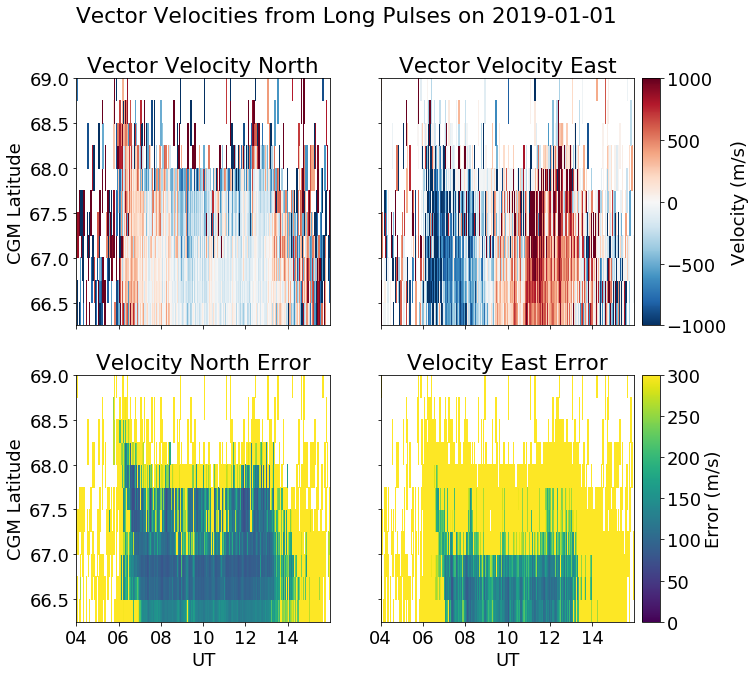

In [10]:
vdat=vvels_data[0]
plt.rcParams['figure.figsize']=10,10
plt.rcParams['font.size']=18
fig,axarr=plt.subplots(2,2,sharex=True,sharey=True)

vclrs=axarr[0,0].pcolormesh(mdates.date2num(vdat['time']),vdat['cgm_lat'],vdat['vipn'],vmin=-1000,vmax=1000,cmap='RdBu_r')
errclrs=axarr[1,0].pcolormesh(mdates.date2num(vdat['time']),vdat['cgm_lat'],vdat['dvipn'],vmin=0,vmax=300,cmap='viridis')

vclrs=axarr[0,1].pcolormesh(mdates.date2num(vdat['time']),vdat['cgm_lat'],vdat['vipe'],vmin=-1000,vmax=1000,cmap='RdBu_r')
errclrs=axarr[1,1].pcolormesh(mdates.date2num(vdat['time']),vdat['cgm_lat'],vdat['dvipe'],vmin=0,vmax=300,cmap='viridis')

axarr[-1,0].set_xlim([mdates.date2num(datetime.datetime(2019,1,1,4,0,0)),mdates.date2num(datetime.datetime(2019,1,1,16,0,0))])
axarr[-1,0].set_xticks(np.arange(mdates.date2num(datetime.datetime(2019,1,1,4,0,0)),mdates.date2num(datetime.datetime(2019,1,1,16,0,0)),2.0/24.0))
axarr[-1,1].set_xlim([mdates.date2num(datetime.datetime(2019,1,1,4,0,0)),mdates.date2num(datetime.datetime(2019,1,1,16,0,0))])
axarr[-1,1].set_xticks(np.arange(mdates.date2num(datetime.datetime(2019,1,1,4,0,0)),mdates.date2num(datetime.datetime(2019,1,1,16,0,0)),2.0/24.0))

axarr[-1,0].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
axarr[-1,0].set_xlabel('UT')
axarr[-1,1].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
axarr[-1,1].set_xlabel('UT')

axarr[0,0].set_ylabel('CGM Latitude')
axarr[1,0].set_ylabel('CGM Latitude')

axarr[0,0].set_title('Vector Velocity North')
axarr[0,1].set_title('Vector Velocity East')

axarr[1,0].set_title('Velocity North Error')
axarr[1,1].set_title('Velocity East Error')

fig.suptitle('Vector Velocities from Long Pulses on 2019-01-01')

box=axarr[0,1].get_position()
vcbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
vcb=plt.colorbar(vclrs,cax=vcbarax)
vcb.set_label('Velocity (m/s)')

box=axarr[1,1].get_position()
errcbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
errcb=plt.colorbar(errclrs,cax=errcbarax)
errcb.set_label('Error (m/s)')

In [11]:
for i,d in enumerate(LP_data):
    print(d['bid'],d['azm'],d['elm'])

63197.0 -35.09 66.19
63239.0 -16.23 58.68
63281.0 -2.95 47.55
63365.0 76.09 66.19
63401.0 57.23 58.68
63449.0 43.95 47.55
64016.0 14.04 90.0
64037.0 20.5 76.0
64055.0 20.5 64.0
64079.0 20.5 50.0
64157.0 -154.3 77.5


In [12]:
#Pick out three beams
east=0
for i,d in enumerate(AC_data):
    if d['azm']==57.23:
        east=i
eacdat=AC_data[east]
east=0
for i,d in enumerate(LP_data):
    if d['azm']==57.23:
        east=i
elpdat=LP_data[east]

north=0
for i,d in enumerate(AC_data):
    if d['azm']==20.5 and d['elm']==50.0:
        north=i
nacdat=AC_data[north]       
north=0
for i,d in enumerate(LP_data):
    if d['azm']==20.5 and d['elm']==50.0:
        north=i
nlpdat=LP_data[north]

west=0
for i,d in enumerate(AC_data):
    if d['azm']==-16.23:
        west=i
wacdat=AC_data[west]
west=0
for i,d in enumerate(LP_data):
    if d['azm']==-16.23:
        west=i
wlpdat=LP_data[west]

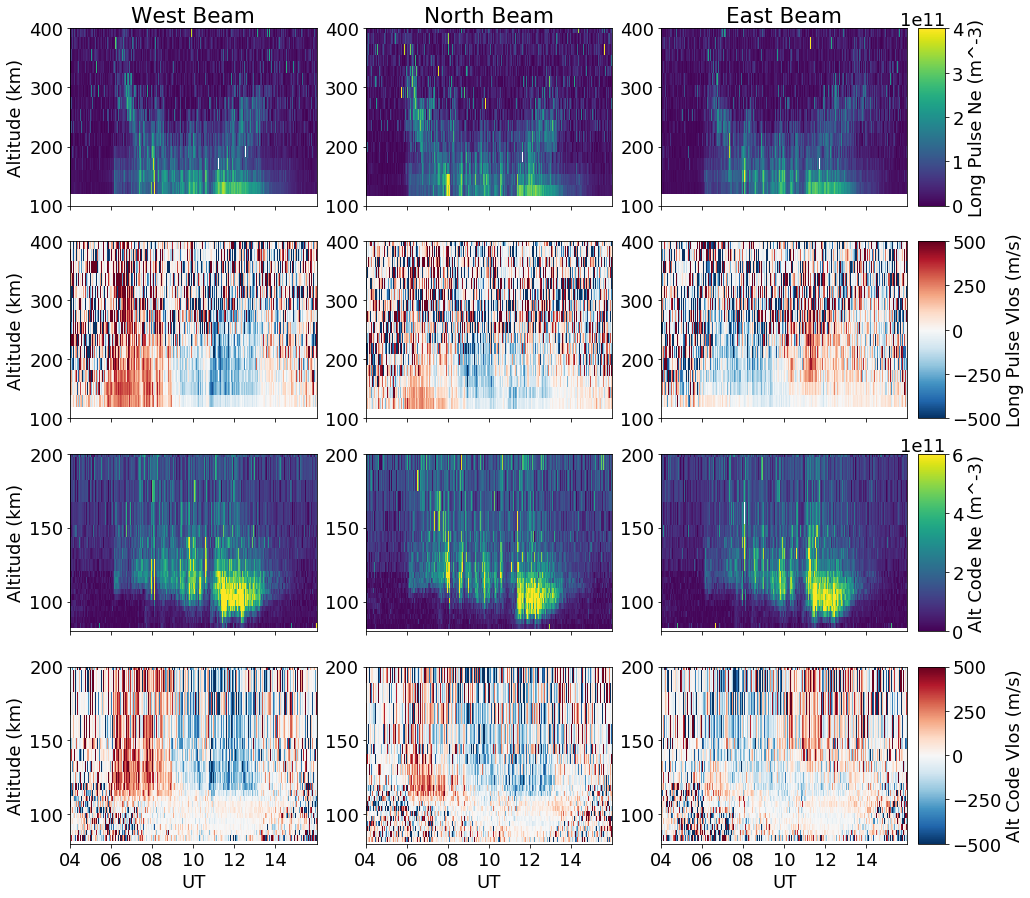

In [13]:
plt.rcParams['figure.figsize']=15,15
plt.rcParams['font.size']=18
fig,axarr=plt.subplots(4,3,sharex=True)

nelpclrs = axarr[0,0].pcolormesh(mdates.date2num(wlpdat['time']),wlpdat['altitude'],wlpdat['ne'],vmin=0,vmax=4e11,cmap='viridis')
axarr[0,0].set_ylim([100,400])

nelpclrs = axarr[0,1].pcolormesh(mdates.date2num(nlpdat['time']),nlpdat['altitude'],nlpdat['ne'],vmin=0,vmax=4e11,cmap='viridis')
axarr[0,1].set_ylim([100,400])

nelpclrs = axarr[0,2].pcolormesh(mdates.date2num(elpdat['time']),elpdat['altitude'],elpdat['ne'],vmin=0,vmax=4e11,cmap='viridis')
axarr[0,2].set_ylim([100,400])

volpclrs = axarr[1,0].pcolormesh(mdates.date2num(wlpdat['time']),wlpdat['altitude'],wlpdat['vo'],vmin=-500,vmax=500,cmap='RdBu_r')
axarr[1,0].set_ylim([100,400])

volpclrs = axarr[1,1].pcolormesh(mdates.date2num(nlpdat['time']),nlpdat['altitude'],nlpdat['vo'],vmin=-500,vmax=500,cmap='RdBu_r')
axarr[1,1].set_ylim([100,400])

volpclrs = axarr[1,2].pcolormesh(mdates.date2num(elpdat['time']),elpdat['altitude'],elpdat['vo'],vmin=-500,vmax=500,cmap='RdBu_r')
axarr[1,2].set_ylim([100,400])

neacclrs = axarr[2,0].pcolormesh(mdates.date2num(wacdat['time']),wacdat['altitude'],wacdat['ne'],vmin=0,vmax=6e11,cmap='viridis')
axarr[2,0].set_ylim([80,200])

neacclrs = axarr[2,1].pcolormesh(mdates.date2num(nacdat['time']),nacdat['altitude'],nacdat['ne'],vmin=0,vmax=6e11,cmap='viridis')
axarr[2,1].set_ylim([80,200])

neacclrs = axarr[2,2].pcolormesh(mdates.date2num(eacdat['time']),eacdat['altitude'],eacdat['ne'],vmin=0,vmax=6e11,cmap='viridis')
axarr[2,2].set_ylim([80,200])

voacclrs = axarr[3,0].pcolormesh(mdates.date2num(wacdat['time']),wacdat['altitude'],wacdat['vo'],vmin=-500,vmax=500,cmap='RdBu_r')
axarr[3,0].set_ylim([80,200])

voacclrs = axarr[3,1].pcolormesh(mdates.date2num(nacdat['time']),nacdat['altitude'],nacdat['vo'],vmin=-500,vmax=500,cmap='RdBu_r')
axarr[3,1].set_ylim([80,200])

voacclrs = axarr[3,2].pcolormesh(mdates.date2num(eacdat['time']),eacdat['altitude'],eacdat['vo'],vmin=-500,vmax=500,cmap='RdBu_r')
axarr[3,2].set_ylim([80,200])

axarr[-1,0].set_xlim([mdates.date2num(datetime.datetime(2019,1,1,4,0,0)),mdates.date2num(datetime.datetime(2019,1,1,16,0,0))])
axarr[-1,0].set_xticks(np.arange(mdates.date2num(datetime.datetime(2019,1,1,4,0,0)),mdates.date2num(datetime.datetime(2019,1,1,16,0,0)),2.0/24.0))
axarr[-1,1].set_xlim([mdates.date2num(datetime.datetime(2019,1,1,4,0,0)),mdates.date2num(datetime.datetime(2019,1,1,16,0,0))])
axarr[-1,1].set_xticks(np.arange(mdates.date2num(datetime.datetime(2019,1,1,4,0,0)),mdates.date2num(datetime.datetime(2019,1,1,16,0,0)),2.0/24.0))
axarr[-1,2].set_xlim([mdates.date2num(datetime.datetime(2019,1,1,4,0,0)),mdates.date2num(datetime.datetime(2019,1,1,16,0,0))])
axarr[-1,2].set_xticks(np.arange(mdates.date2num(datetime.datetime(2019,1,1,4,0,0)),mdates.date2num(datetime.datetime(2019,1,1,16,0,0)),2.0/24.0))

axarr[-1,0].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
axarr[-1,0].set_xlabel('UT')
axarr[-1,1].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
axarr[-1,1].set_xlabel('UT')
axarr[-1,2].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
axarr[-1,2].set_xlabel('UT')

axarr[0,0].set_ylabel('Altitude (km)')
axarr[1,0].set_ylabel('Altitude (km)')
axarr[2,0].set_ylabel('Altitude (km)')
axarr[3,0].set_ylabel('Altitude (km)')

axarr[0,0].set_title('West Beam')
axarr[0,1].set_title('North Beam')
axarr[0,2].set_title('East Beam')

box=axarr[0,-1].get_position()
nelpcbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
nelpcb=plt.colorbar(nelpclrs,cax=nelpcbarax)
nelpcb.set_label('Long Pulse Ne (m^-3)')

box=axarr[1,-1].get_position()
volpcbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
volpcb=plt.colorbar(volpclrs,cax=volpcbarax)
volpcb.set_label('Long Pulse Vlos (m/s)')

box=axarr[2,-1].get_position()
neaccbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
neaccb=plt.colorbar(neacclrs,cax=neaccbarax)
neaccb.set_label('Alt Code Ne (m^-3)')

box=axarr[3,-1].get_position()
voaccbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
voaccb=plt.colorbar(voacclrs,cax=voaccbarax)
voaccb.set_label('Alt Code Vlos (m/s)')

Hint: You may find the SuperDARN convection maps useful for interpreting this. For example look at the map from 08:00 UT on this day.

http://vt.superdarn.org/tiki-index.php?page=Conv+map+overview